# Unsupervised methods

### Preprocess the dataset for clustering algorithms.

Using only selected features
Transform the features to follow a normal distribution

In [1]:
import pandas as pd

df = pd.read_csv('temp/Delivery_truck_trip_data.csv')

In [2]:
columns1 = ['OriginLocation_Code', 'vehicle_no', 'TRANSPORTATION_DISTANCE_IN_KM', 'vehicleType', 'Minimum_kms_to_be_covered_in_a_day', 'supplierID', 'trip_time', 'day', 'month', 'year']

In [7]:
df.reset_index(drop=True, inplace=True)
X = df.drop(['ontime'], axis=1)
y = df['ontime']

from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
columns = ['Market/Regular', 'vehicle_no', 'OriginLocation_Code', 'DestinationLocation_Code', 'vehicleType', 'Minimum_kms_to_be_covered_in_a_day', 'customerID', 'supplierID', 'Material Shipped', 'dayofweek']
X[columns] = encoder.fit_transform(X[columns])

X = X[columns1]

from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal')
X = qt.fit_transform(X)

### Create a Table of performance

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, rand_score, adjusted_mutual_info_score, homogeneity_score, completeness_score, v_measure_score

table_of_performance = pd.DataFrame(columns=['algorithm', 'confusion matrix', 'accuracy', 'precision', 'recall', 'rand index', 'mutual information based score', 'homogeneity', 'completeness', 'v-measure'])

def add_performance(algorithm, y_test, y_predict):
    global table_of_performance

    cm = confusion_matrix(y_test, y_predict)
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    rand_index = rand_score(y_test, y_predict)
    mutual_info_score = adjusted_mutual_info_score(y_test, y_predict)
    homogeneity = homogeneity_score(y_test, y_predict)
    completeness = completeness_score(y_test, y_predict)
    v_measure = v_measure_score(y_test, y_predict)
    
    new_row = {'algorithm': algorithm, 'confusion matrix': cm, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'rand index': rand_index, 'mutual information based score': mutual_info_score, 'homogeneity': homogeneity, 'completeness': completeness, 'v-measure': v_measure}

    table_of_performance.loc[len(table_of_performance)] = new_row

### Visualization of clustering after PCA

<Axes: xlabel='x', ylabel='y'>

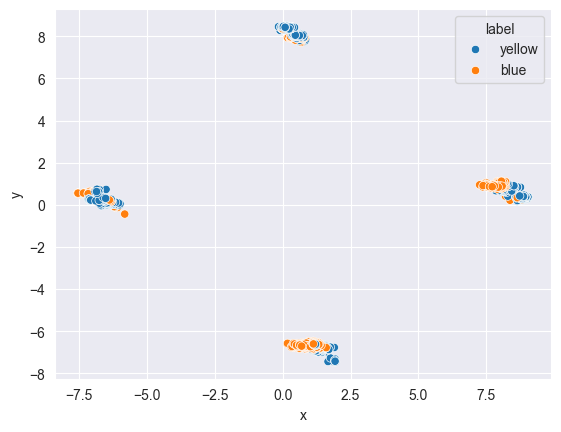

In [9]:
from sklearn.decomposition import  PCA
import numpy as np

pca = PCA(n_components=2)
pct = pca.fit_transform(X)

pct = np.delete(pct, 6745, 0)
y_new = np.delete(y.to_numpy(), 6745, 0)

y_new = ['yellow' if elem else 'blue' for elem in y_new]

data = pd.concat([pd.DataFrame(pct), pd.DataFrame(y_new)], axis=1)

data.columns = ['x', 'y', 'label']
import seaborn as sns

sns.scatterplot(data=data, x="x", y="y", hue="label")

### KMeans

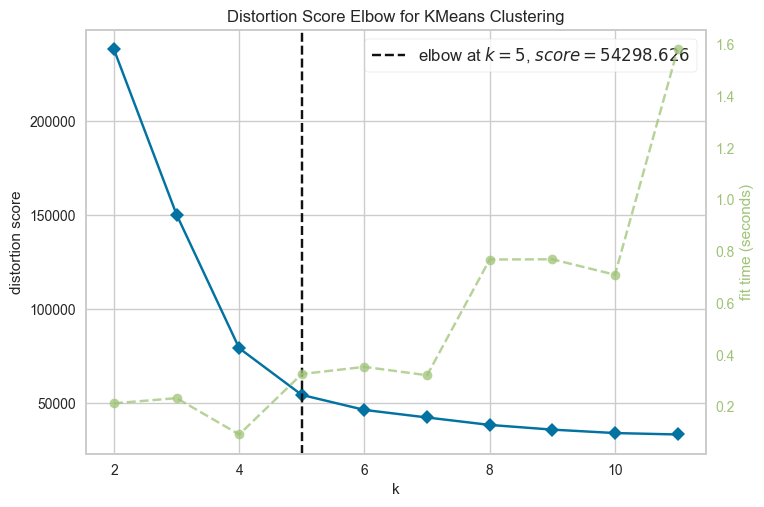

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [548]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 12))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()

The optimal number of clusters is 5.

In [498]:
k_means = KMeans(init="k-means++", n_clusters=2, n_init=10)
k_means.fit(X)

from sklearn.metrics.pairwise import pairwise_distances_argmin

k_means_cluster_centers = k_means.cluster_centers_

k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)

from sklearn.metrics.pairwise import pairwise_distances_argmin_min

k_means_distances_df = pd.DataFrame(pairwise_distances_argmin_min(X, k_means_cluster_centers)).T
k_means_distances_df.columns = ['cluster', 'distance']

k_means_distances_df = pd.concat([k_means_distances_df, y], axis=1)
print(k_means_distances_df.groupby(['cluster', 'ontime']).mean())
print(k_means_distances_df.groupby(['cluster', 'ontime']).count())

                distance
cluster ontime          
0.0     False   1.582688
        True    1.919439
1.0     False   4.629075
        True    2.768444
2.0     False   3.024702
        True    2.869519
3.0     False   3.615190
        True    3.037878
4.0     False   1.785378
        True    1.893223
                distance
cluster ontime          
0.0     False        800
        True          28
1.0     False        219
        True        1789
2.0     False        819
        True         420
3.0     False        182
        True         569
4.0     False        500
        True        1424


Let's say that points belongs to cluster 0 and 2 are anomalies. Recall is 64% and precision is 78%.

### Affinity Propagation

In [499]:
from scipy.spatial.distance import pdist

max(pdist(X))

20.42307758680376

In [550]:
from sklearn.cluster import AffinityPropagation

pca = PCA(n_components=3)
pct = pca.fit_transform(X)
af = AffinityPropagation(random_state=0).fit(pct)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_
len(cluster_centers_indices)

1704

I tried different values of preferences based on longest distance between points and PCA Affinity propagation doesn't work

### Mean Shift

In [562]:
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(X, quantile=0.3)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

In [563]:
mean_shift_distances_df = pd.DataFrame(pairwise_distances_argmin_min(X, cluster_centers)).T
mean_shift_distances_df.columns = ['cluster', 'distance']
mean_shift_distances_df = pd.concat([mean_shift_distances_df, y], axis=1)
mean_shift_distances_df.groupby(['cluster', 'ontime']).mean()

distance
cluster ontime          
0.0     False   4.031270
        True    2.812542
1.0     False   4.629075
        True    2.768444
2.0     False   3.024702
        True    2.869519
3.0     False   3.615190
        True    3.037878

In [564]:
mean_shift_distances_df.groupby(['cluster', 'ontime']).count()

distance
cluster ontime          
0.0     False       1300
        True        1452
1.0     False        219
        True        1789
2.0     False        819
        True         420
3.0     False        182
        True         569

In cluster 1 and 3, most are on time. In cluster 2, most are not on time. In clusters 0, almost half of the points are anomalies.

### Spectral clustering

In [566]:
from sklearn.cluster import SpectralClustering

clustering = SpectralClustering(n_clusters=4, assign_labels='discretize', random_state=0).fit(X)
spectral_clustering = clustering

In [625]:
import joblib

joblib.dump(spectral_clustering, 'spectral_clustering_model.pkl')

['spectral_clustering_model.pkl']

In [626]:
loaded_model = joblib.load('spectral_clustering_model.pkl')

In [630]:
pd.DataFrame(loaded_model.labels_).value_counts()

0    6425
2     192
3      79
1      54
Name: count, dtype: int64

In [582]:
spectral_clustering_labels_df = pd.DataFrame(spectral_clustering.labels_, columns=['cluster'])
spectral_clustering_labels_df = pd.concat([spectral_clustering_labels_df, y], axis=1)
spectral_clustering_labels_df

,cluster,ontime
0,0,True
1,0,False
2,0,False
3,0,False
4,0,False
...,...,...
6745,0,False
6746,2,False
6747,0,False
6748,0,True


In [631]:
spectral_clustering_labels_df['cluster'].value_counts()

cluster
0    6425
2     192
3      79
1      54
Name: count, dtype: int64

In [583]:
spectral_clustering_labels_df.value_counts()

cluster  ontime
0        True      4020
         False     2405
2        True       117
         False       75
3        True        69
1        False       30
         True        24
3        False       10
Name: count, dtype: int64

In [577]:
spectral_df.value_counts()

cluster  ontime
1        True      1789
0        True      1452
         False     1300
2        False      819
3        True       569
2        True       420
1        False      219
3        False      182
Name: count, dtype: int64

In cluster 2, almost half are anomalies. In cluster 0 and 3, most are not anomalies. In cluster 1 most are anomalies.

### Hierarchical clustering

In [591]:
from sklearn.cluster import AgglomerativeClustering

hierarchical_clustering = AgglomerativeClustering(n_clusters=5).fit(X)

In [1]:
hierarchical_clustering_labels_df = pd.DataFrame(hierarchical_clustering.labels_, columns=['cluster'])
hierarchical_clustering_labels_df = pd.concat([hierarchical_clustering_labels_df, y], axis=1)
pd.DataFrame(hierarchical_clustering_labels_df.value_counts())

NameError: name 'pd' is not defined

In clusters 0, 1 and 3, most of the data points are not anomalies (are on time). In cluster 2, most of the data are anomalies(are not ontime). In cluster 4, all of the data points are anomalies.

### HDBSCAN

In [594]:
from sklearn.cluster import HDBSCAN

hdb = HDBSCAN(min_cluster_size=20)
hdb.fit(X)

HDBSCAN(min_cluster_size=20)

In [604]:
hdbscan_labels_df = pd.DataFrame(hdb.labels_, columns=['clusters'])
hdbscan_labels_df = pd.concat([hdbscan_labels_df, y], axis=1)
hdbscan_labels_df[hdbscan_labels_df.clusters==-1].value_counts()

clusters  ontime
-1        False     473
          True      439
Name: count, dtype: int64

HDBSCAN doesn't work well.

### OPTICS

In [611]:
from sklearn.cluster import OPTICS

optics = OPTICS(min_samples=2).fit(X)

In [613]:
optics_labels_df = pd.DataFrame(optics.labels_, columns=['clusters'])
optics_labels_df = pd.concat([optics_labels_df, y], axis=1)
optics_labels_df[optics_labels_df.clusters==-1].value_counts()

clusters  ontime
-1        True      826
          False     516
Name: count, dtype: int64

OPTICS also doesn't work well.

### BIRCH

In [620]:
from sklearn.cluster import Birch

brc = Birch(n_clusters=5)
brc.fit(X)
brc.predict(X)

array([4, 4, 4, ..., 2, 2, 2])

In [623]:
brc_labels_df = pd.DataFrame(brc.labels_, columns=['clusters'])
brc_labels_df = pd.concat([brc_labels_df, y], axis=1)
brc_labels_df.value_counts()

clusters  ontime
0         True      1789
3         True      1424
2         False      819
4         False      800
1         True       569
3         False      500
2         True       420
0         False      219
1         False      182
4         True        28
Name: count, dtype: int64

In clusters 0, 1 and 3, most are anomalies. In cluster 2 and 4, most are not anomalies.